In [1]:
import numpy as np
import preprocessing as pre
from forward_feed_nn import NeuralNetwork
import pickle
from sklearn.model_selection import KFold
import testing
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
import preprocessing as pre
from tensorflow.keras.callbacks import EarlyStopping

### Load and preprocess the data

In [ ]:
X, y = pre.load_data('../data/fashion_train.npy')
pca = pickle.load(open('./models/pca_65.pkl', 'rb'))
X_processed = pre.preprocess(X,pca)

### Hyperparameter optimization with (from scratch) grid search 

In [ ]:
# define search space
layer_options = [[X_processed.shape[1], 128, 5], 
                 [X_processed.shape[1], 256, 128, 5], 
                 [X_processed.shape[1], 512, 256, 128, 5]]
dropout_rates = [0, 0.2, 0.3, 0.5]
learning_rates = [0.001, 0.01, 0.1]

best_HP = {}
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42) # use KFold class for kfold

for layers in layer_options:
    for dropout in dropout_rates:
        for learning in learning_rates:
            # for every combination of parameters in our search space, do cross validation
            fold_accuracies = []
            for train_index, val_index in kf.split(X_processed):
                # get the train and validation data from the kfold indices
                X_train, X_val = X_processed[train_index], X_processed[val_index]
                y_train, y_val = y[train_index], y[val_index]

                # train our neural network on the data
                nn = NeuralNetwork(layer_sizes=layers, learning_rate=learning, dropout_rate=dropout)
                nn.train(X_train, y_train, epochs=100)

                # predict and store accuracy
                predictions = nn.predict(X_val)
                accuracy = nn.accuracy(predictions, y_val)
                fold_accuracies.append(accuracy)

            # store mean fold accuracy for evaluating the models
            mean_accuracy = np.mean(fold_accuracies)
            print(f"Layers: {layers}, Dropout: {dropout}, Learning Rate: {learning}, Mean Accuracy: {mean_accuracy}")
            best_HP[mean_accuracy] = (layers, dropout, mean_accuracy, learning)

# get the parameters that resulted in the highest accuracy
best_accuracy = max(best_HP)
print("Best Hyperparameters:")
print(f"Layers: {best_HP[best_accuracy][0]}, Dropout: {best_HP[best_accuracy][1]}, Accuracy: {best_HP[best_accuracy][2]}, Learning Rate: {best_HP[best_accuracy][3]}")


### Best combination of parameters
- layer: [65, 512, 256, 128, 5]
- dropout: 0.2
- learning rate: 0.1

### Creating the optimal model

In [ ]:
# code to create and save the model based on the optimal parameters
nn = NeuralNetwork(layer_sizes=[65, 512, 256, 128, 5],dropout_rate=0.2,learning_rate=0.1)
nn.train(X_processed,y,epochs=100)

In [ ]:
# save the model
with open('./models/forward_feed_nn_model.pkl', 'wb') as f:
    pickle.dump(nn, f)

### Testing our implementation

In [ ]:
nn_results = testing.bootstrapping_test(model_filepath="models/forward_feed_nn_model.pkl")

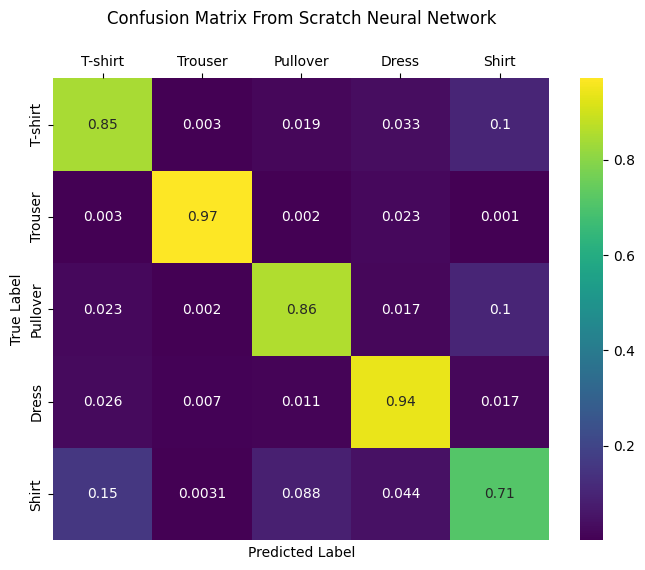

In [4]:
testing.plot_confusion_matrix(nn_results["cm"],title="Confusion Matrix From Scratch Neural Network")

### Create reference implementation

#### Training

In [ ]:
# Hyperparameters based on our grid search
input_size = X_processed.shape[1]
hidden_layers = [512, 256, 128]  
output_size = 5 
dropout_rate = 0.2 
learning_rate = 0.1

# Build the model
model = Sequential()

# Use same activation functions as in our implementation
model.add(Dense(hidden_layers[0], input_shape=(input_size,), activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(hidden_layers[1], activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(hidden_layers[2], activation='relu'))
model.add(Dropout(dropout_rate))

model.add(Dense(output_size, activation='softmax'))

# Tensorflow doesn't have mini-batch gradient descent so it uses stochastic gradient descent
model.compile(optimizer=SGD(learning_rate=learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   
    patience=7,           
    restore_best_weights=True
)

# Split data for validation during training
# Tensorflow uses validation data which we don't use during our training
X_train,X_val,y_train,y_val = train_test_split(X_processed,y,test_size=0.3,random_state=42,stratify=y)


history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  
)


In [ ]:
# save the reference neural network model
with open('./models/forward_feed_reference_nn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

### Reference test

In [ ]:
nn_reference_results = testing.bootstrapping_test("./models/forward_feed_reference_nn_model.pkl")

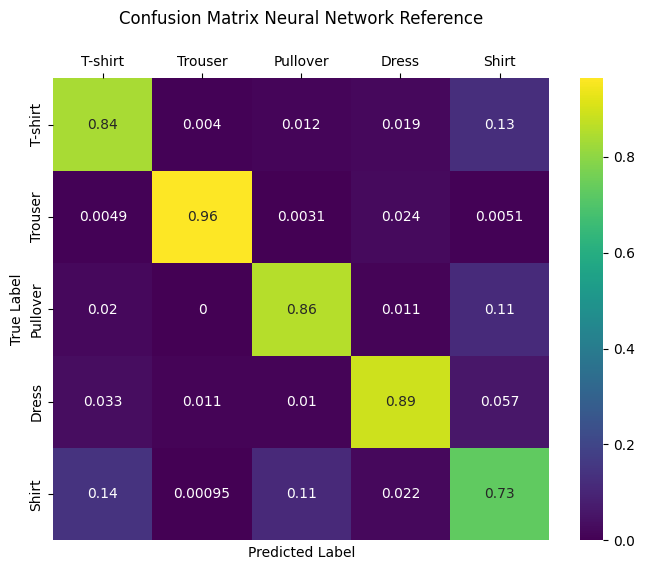

In [6]:
testing.plot_confusion_matrix(nn_reference_results["cm"],title="Confusion Matrix Neural Network Reference")